In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
from google.colab import files
uploaded = files.upload()


Saving stroke_prediction_dataset.csv to stroke_prediction_dataset (1).csv


In [6]:
import pandas as pd

# Load your uploaded file (replace with actual name shown in Colab after upload)
df = pd.read_csv("stroke_prediction_dataset.csv")

df.head()


,Patient ID,Patient Name,Age,Gender,Hypertension,Heart Disease,Marital Status,Work Type,Residence Type,Average Glucose Level,...,Alcohol Intake,Physical Activity,Stroke History,Family History of Stroke,Dietary Habits,Stress Levels,Blood Pressure Levels,Cholesterol Levels,Symptoms,Diagnosis
0,18153,Mamooty Khurana,56,Male,0,1,Married,Self-employed,Rural,130.91,...,Social Drinker,Moderate,0,Yes,Vegan,3.48,140/108,"HDL: 68, LDL: 133","Difficulty Speaking, Headache",Stroke
1,62749,Kaira Subramaniam,80,Male,0,0,Single,Self-employed,Urban,183.73,...,Never,Low,0,No,Paleo,1.73,146/91,"HDL: 63, LDL: 70","Loss of Balance, Headache, Dizziness, Confusion",Stroke
2,32145,Dhanush Balan,26,Male,1,1,Married,Never Worked,Rural,189.00,...,Rarely,High,0,Yes,Paleo,7.31,154/97,"HDL: 59, LDL: 95","Seizures, Dizziness",Stroke
3,6154,Ivana Baral,73,Male,0,0,Married,Never Worked,Urban,185.29,...,Frequent Drinker,Moderate,0,No,Paleo,5.35,174/81,"HDL: 70, LDL: 137","Seizures, Blurred Vision, Severe Fatigue, Head...",No Stroke
4,48973,Darshit Jayaraman,51,Male,1,1,Divorced,Self-employed,Urban,177.34,...,Rarely,Low,0,Yes,Pescatarian,6.84,121/95,"HDL: 65, LDL: 68",Difficulty Speaking,Stroke


In [7]:
from collections import Counter
import re

# --- Clean column names ---
df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(' ', '_', regex=False)
              .str.replace('/', '_', regex=False)
              .str.replace('-', '_', regex=False)
)

# --- Encode categorical variables (including smoking_status) ---
categorical_columns = [
    'gender', 'marital_status', 'work_type', 'residence_type',
    'smoking_status', 'alcohol_intake', 'physical_activity',
    'family_history_of_stroke', 'dietary_habits'
]

for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].fillna('missing').astype('category').cat.codes

# --- Split Blood Pressure Levels (e.g. "140/108") ---
if 'blood_pressure_levels' in df.columns:
    bp = df['blood_pressure_levels'].astype(str).str.extract(r'(\d+)\D+(\d+)', expand=True)
    df['systolic_bp'] = pd.to_numeric(bp[0], errors='coerce')
    df['diastolic_bp'] = pd.to_numeric(bp[1], errors='coerce')

# --- Split Cholesterol Levels (e.g. "HDL: 68, LDL: 133") ---
if 'cholesterol_levels' in df.columns:
    hdl = df['cholesterol_levels'].astype(str).str.extract(r'HDL[:\s]*?(\d+)', expand=False)
    ldl = df['cholesterol_levels'].astype(str).str.extract(r'LDL[:\s]*?(\d+)', expand=False)
    df['hdl'] = pd.to_numeric(hdl, errors='coerce')
    df['ldl'] = pd.to_numeric(ldl, errors='coerce')

# --- Process Symptoms ---
if 'symptoms' in df.columns:
    symptoms_lists = df['symptoms'].fillna('').apply(
        lambda x: [s.strip().lower() for s in str(x).split(',') if s.strip()]
    )
    df['num_symptoms'] = symptoms_lists.apply(len)

    cnt = Counter()
    for lst in symptoms_lists:
        cnt.update(lst)
    top10 = [s for s, _ in cnt.most_common(10)]

    for s in top10:
        safe = re.sub(r'[^0-9a-z_]', '_', s.replace(' ', '_'))
        colname = f'symptom_{safe}'
        df[colname] = symptoms_lists.apply(lambda lst: int(s in lst))

# --- Encode Diagnosis (Stroke=1, No Stroke=0) ---
if 'diagnosis' in df.columns:
    df['diagnosis_enc'] = df['diagnosis'].astype(str).str.lower().apply(
        lambda x: 1 if ('stroke' in x and 'no' not in x) else 0
    )

# --- Keep only numeric columns for ML ---
numeric_df = df.select_dtypes(include=['number']).copy()

print("✅ Final numeric dataset shape:", numeric_df.shape)
display(numeric_df.head())


✅ Final numeric dataset shape: (15000, 33)


,patient_id,age,gender,hypertension,heart_disease,marital_status,work_type,residence_type,average_glucose_level,body_mass_index_(bmi),...,symptom_dizziness,symptom_loss_of_balance,symptom_confusion,symptom_seizures,symptom_difficulty_speaking,symptom_weakness,symptom_numbness,symptom_blurred_vision,symptom_severe_fatigue,diagnosis_enc
0,18153,56,1,0,1,1,3,0,130.91,22.37,...,0,0,0,0,1,0,0,0,0,1
1,62749,80,1,0,0,2,3,1,183.73,32.57,...,1,1,1,0,0,0,0,0,0,1
2,32145,26,1,1,1,1,1,0,189.00,20.32,...,1,0,0,1,0,0,0,0,0,1
3,6154,73,1,0,0,1,1,1,185.29,27.50,...,0,0,1,1,0,0,0,1,1,0
4,48973,51,1,1,1,0,3,1,177.34,29.06,...,0,0,0,0,1,0,0,0,0,1


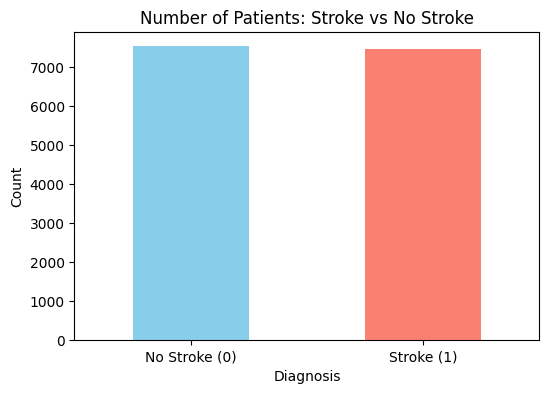

In [8]:
import matplotlib.pyplot as plt

# Make sure diagnosis_enc exists (1=Stroke, 0=No Stroke)
if 'diagnosis_enc' not in df.columns:
    print("⚠️ diagnosis_enc not found, make sure you ran the encoding step.")
else:
    # Count plot: number of patients with/without stroke
    stroke_counts = df['diagnosis_enc'].value_counts()

    plt.figure(figsize=(6,4))
    stroke_counts.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.xticks([0,1], ['No Stroke (0)', 'Stroke (1)'], rotation=0)
    plt.title("Number of Patients: Stroke vs No Stroke")
    plt.ylabel("Count")
    plt.xlabel("Diagnosis")
    plt.show()


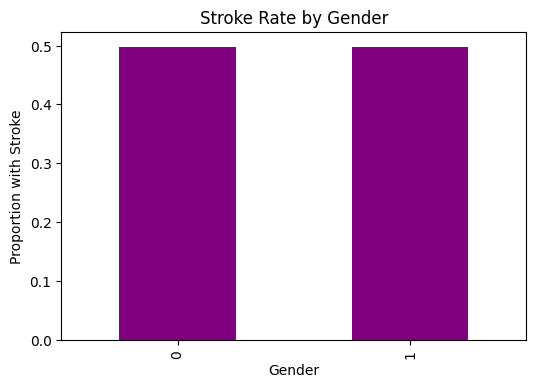

In [9]:
if 'gender' in df.columns:
    gender_stroke = df.groupby('gender')['diagnosis_enc'].mean()

    plt.figure(figsize=(6,4))
    gender_stroke.plot(kind='bar', color='purple')
    plt.title("Stroke Rate by Gender")
    plt.ylabel("Proportion with Stroke")
    plt.xlabel("Gender")
    plt.show()


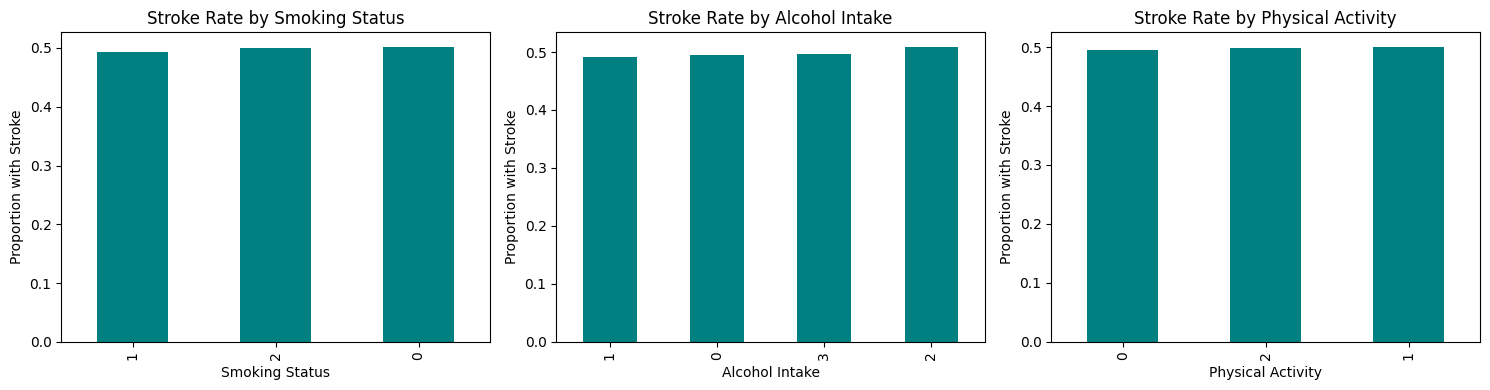

In [10]:
import matplotlib.pyplot as plt

# List of lifestyle-related columns to compare against stroke
cols_to_plot = ['smoking_status', 'alcohol_intake', 'physical_activity']

plt.figure(figsize=(15, 4))

for i, col in enumerate(cols_to_plot, 1):
    if col in df.columns:
        plt.subplot(1, 3, i)
        stroke_rate = df.groupby(col)['diagnosis_enc'].mean().sort_values()
        stroke_rate.plot(kind='bar', color='teal')
        plt.title(f"Stroke Rate by {col.replace('_',' ').title()}")
        plt.ylabel("Proportion with Stroke")
        plt.xlabel(col.replace('_',' ').title())
    else:
        print(f"⚠️ Column '{col}' not found in dataframe")

plt.tight_layout()
plt.show()
